In [31]:
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import pcntoolkit as ptk
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from pcntoolkit.util.utils import calibration_descriptives
from pcntoolkit.model.hbr import bspline_fit, bspline_transform
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from pcntoolkit.util.hbr_utils import *
import sklearn

In [70]:
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_train.pkl', 'rb') as file:
    Z_all = pickle.load(file)
all_sites = np.unique(Z_all['site_id'])

with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/patient_levels.txt','rb') as file:
    levels = list(pickle.load(file).to_numpy())
levels.insert(0,'Healthy')

In [3]:
# Extract some patient data
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/X_patient.pkl', 'rb') as file:
    X_patient = pickle.load(file)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/Y_patient.pkl', 'rb') as file:
    Y_patient = pickle.load(file)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/Z_patient.pkl', 'rb') as file:
    Z_patient = pickle.load(file)
labels_patient = np.loadtxt('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/patient_labels.txt')[:,None]
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/X_test.pkl', 'rb') as file:
    X_control = pickle.load(file)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Y_test.pkl', 'rb') as file:
    Y_control = pickle.load(file)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_test.pkl', 'rb') as file:
    Z_control = pickle.load(file)
labels_control = np.zeros_like(Z_control)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Y_train.pkl', 'rb') as file:
    Y_train = pickle.load(file)
with open('/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_train.pkl', 'rb') as file:
    Z_train = pickle.load(file)
labels_train = np.zeros_like(Z_train)

In [74]:
np.random.seed(70)
idx = np.random.choice(X_control.shape[0], 500, replace=False)
all_Xs = np.concatenate((X_patient.to_numpy(), X_control.to_numpy()[idx]), axis = 0)
all_Zs = np.concatenate((Z_patient.to_numpy(), Z_control.to_numpy()[idx]), axis = 0)
all_Ys = np.concatenate((Y_patient.to_numpy(), Y_control.to_numpy()[idx]), axis = 0)
all_labels = np.concatenate((labels_patient, labels_control[idx]), axis = 0)
all_features_baseline = np.concatenate(( all_Xs, all_Ys, all_Zs), axis = 1)
# all_features_baseline = all_Ys.copy()

all_features_baseline = (all_features_baseline-all_features_baseline.mean(axis=0, keepdims = True))/all_features_baseline.std(axis = 0, keepdims = True)
X_base_train, X_base_test, Y_base_train, Y_base_test = train_test_split(all_features_baseline, all_labels, stratify = all_labels, random_state = 42)

0.5721518987341773


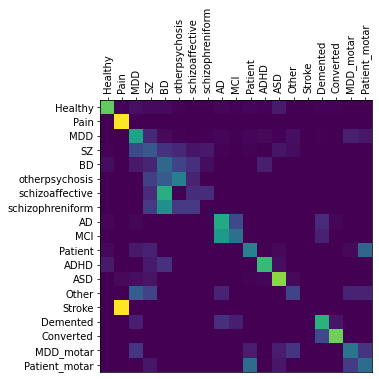

In [97]:
classy = SVC(C = 50, kernel='rbf',class_weight='balanced')
classy.fit(X_base_train, np.squeeze(Y_base_train))
Y_base_pred = classy.predict(X_base_test)
print(np.mean(Y_base_pred[:,None] == Y_base_test))
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.imshow(sklearn.metrics.confusion_matrix(Y_base_test, Y_base_pred, normalize='true'))
plt.yticks([i for i in range(len(levels))], levels)
plt.xticks([i for i in range(len(levels))], levels, rotation=90)
ax.xaxis.tick_top()
plt.show()

In [98]:
# For BLR:
Y_blr = np.zeros_like(all_Ys)
all_Phis = create_design_matrix(all_Xs, site_ids = np.squeeze(all_Zs), all_sites=all_sites,basis='bspline')
# For each feature:
for b in range(6):
    model_path = f'10_folds_results/fold_0_blr_sexcov/batch_{b+1}/Models/NM_0_0_estimate.pkl'
    with open(model_path,'rb') as file:
        model = pickle.load(file)
    Yhat, s2 = model.predict(all_Phis)
    this_Y = all_Ys[:,b]
    this_Y_train = Y_train[Y_patient.columns[b]].to_numpy()
    this_Y_s = (this_Y - this_Y_train.mean(axis = 0))/this_Y_train.std(axis=0)
    warped_this_Y_patient = model.warp.f(this_Y_s,model.blr.hyp[1:model.blr.warp.get_n_params()+1])
    this_Z = (warped_this_Y_patient - Yhat)/np.sqrt(s2)
    Y_blr[:,b] = this_Z

In [99]:
all_features_blr = np.concatenate((all_Xs, all_Ys, Y_blr, all_Zs), axis = 1)
# all_features_blr = Y_blr.copy()
all_features_blr = (all_features_blr-all_features_blr.mean(axis=0, keepdims = True))/all_features_blr.std(axis = 0, keepdims = True)
X_blr_train, X_blr_test, Y_blr_train, Y_blr_test = train_test_split(all_features_blr, all_labels, stratify = all_labels, random_state=42)

0.6594936708860759


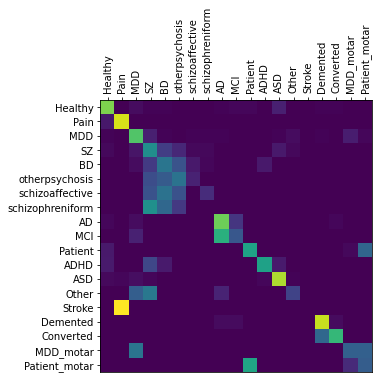

In [108]:
classy = SVC(C = 50, kernel='rbf', class_weight='balanced')
classy.fit(X_blr_train, np.squeeze(Y_blr_train))
Y_blr_pred = classy.predict(X_blr_test)
print(np.mean(Y_blr_pred[:,None] == Y_blr_test))
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.imshow(sklearn.metrics.confusion_matrix(Y_base_test, Y_blr_pred, normalize='true'))
plt.yticks([i for i in range(len(levels))], levels)
plt.xticks([i for i in range(len(levels))], levels, rotation=90)
ax.xaxis.tick_top()
plt.show()

In [109]:
# For SHASHb:
Y_shashb = np.zeros_like(all_Ys)
this_X_S = (all_Xs - X_train.to_numpy().mean(axis = 0))/X_train.to_numpy().std(axis=0)
this_Y_S = (all_Ys - Y_train.to_numpy().mean(axis = 0))/Y_train.to_numpy().std(axis=0)
for b in range(6):
    print(Y_train.columns[b])
    model_path = f'10_folds_results/fold_1_SHASHb_sexcov/batch_{b+1}/Models/NM_0_0_fold1SHASHbsexcov.pkl'        
    with open(model_path,'rb') as file:
        model = pickle.load(file)
    this_X_t = bspline_transform(this_X_S, model.hbr.bsp)
    MAP_path = f'10_folds_results/MAPS/MAP_{b}_SHASHb_fold1_sexcov.pkl'
    with open(MAP_path,'rb') as file:
        MAP = pickle.load(file)
    this_Z = get_single_zscores(this_X_t,this_Y_S[:,b][:,None],all_Zs, model,MAP)
    Y_shashb[:,b] = np.squeeze(this_Z)

Right-Cerebellum-White-Matter
EstimatedTotalIntraCranialVol
Right-Lateral-Ventricle
WM-hypointensities
rh_S_interm_prim-Jensen_thickness
Brain-Stem


In [110]:
all_features_hbr = np.concatenate((all_Xs, all_Ys, Y_shashb, all_Zs), axis = 1)
# all_features_hbr = Y_shashb.copy()
all_features_hbr = (all_features_hbr-all_features_hbr.mean(axis=0, keepdims = True))/all_features_hbr.std(axis = 0, keepdims = True)
X_hbr_train, X_hbr_test, Y_hbr_train, Y_hbr_test = train_test_split(all_features_hbr, all_labels, stratify = all_labels, random_state=42)

0.6430379746835443


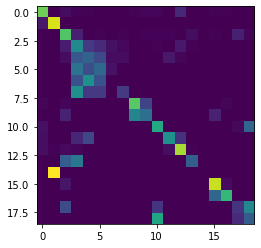

In [111]:
classy = SVC(C = 50, kernel='rbf', class_weight='balanced')
classy.fit(X_hbr_train, np.squeeze(Y_hbr_train))
Y_hbr_pred = classy.predict(X_hbr_test)
print(np.mean(Y_hbr_pred[:,None] == Y_hbr_test))
plt.imshow(sklearn.metrics.confusion_matrix(Y_base_test, Y_hbr_pred, normalize='true'))
plt.show()